# Light curve- Flare

To see the general presentation on our light curve estimator, please refer to the notebook `light_curve.ipynb`

Here we present the way to compute a light curve on time intervals smaller than the duration of an observation.

We will use the Crab nebula observations from the H.E.S.S. first public test data release. We will use time intervals of 15 minutes duration. 

The first important step is to filter the observations to produce shorter observations for each time bin. We can then perform data reduction as before and then estimate the light curve in all of those time bins.

## Setup 

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
from astropy.coordinates import Angle

import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.data import DataStore
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.maps import MapAxis
from gammapy.time import LightCurveEstimator
from gammapy.modeling import Fit
from gammapy.cube import SafeMaskMaker
from gammapy.spectrum import (
    SpectrumDatasetMaker,
    SpectrumDataset,
    ReflectedRegionsBackgroundMaker,
)

## Select the data

We look for relevant observations in the datastore.

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
crab_obs = data_store.get_observations(obs_ids)

## Define time intervals
We create the list of time intervals. Each time interval is an `~astropy.time.Time` object, containing a start and stop time.

In [4]:
time_intervals = [
    ["2004-12-04T22:00", "2004-12-04T22:15"],
    ["2004-12-04T22:15", "2004-12-04T22:30"],
    ["2004-12-04T22:30", "2004-12-04T22:45"],
    ["2004-12-04T22:45", "2004-12-04T23:00"],
    ["2004-12-04T23:00", "2004-12-04T23:15"],
    ["2004-12-04T23:15", "2004-12-04T23:30"],
]
time_intervals = [Time(_) for _ in time_intervals]

## Filter the observations list in time intervals

Here we apply the list of time intervals to the observations with `~gammapy.Observations.select_time`.

This will return a new list of Observations filtered by time_intervals. For each time interval, a new observation is created that convers the intersection of the GTIs and time interval. 

In [5]:
observations = crab_obs.select_time(time_intervals)
# check that observations have been filtered
print(observations[3].gti)

GTI info:
- Number of GTIs: 1
- Duration: 420.00000017881393 s
- Start: 53343.95421509259 MET
- Start: 2004-12-04T22:54:04.184
- Stop: 53343.959076203704 MET
- Stop: 2004-12-04T23:01:04.184



## Building 1D datasets from the new observations

Here we will perform the data reduction in 1D with reflected regions.

Beware, with small time intervals the background normalization with OFF regions might become problematic.

### Defining the geometry

We need to define the ON extraction region. We will keep the same reco and true energy axes as in 3D.

In [6]:
# Target definition
e_reco = MapAxis.from_energy_bounds(0.1, 40, 100, "TeV").edges
e_true = MapAxis.from_energy_bounds(0.05, 100, 100, "TeV").edges

target_position = SkyCoord(83.63308 * u.deg, 22.01450 * u.deg, frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

### Creation of the data reduction makers

We now create the dataset and background makers for the selected geometry.

In [8]:
dataset_maker = SpectrumDatasetMaker(region=on_region, containment_correction=True, selection=["counts", "aeff", "edisp"])
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Creation of the datasets

Now we perform the actual data reduction in the time_intervals.

In [9]:
datasets = []

dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true)

for obs in observations:
    dataset = dataset_maker.run(dataset_empty, obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

### Define the Model

Here we use only a spectral model in the `~gammapy.modeling.models.SkyModel` object.

In [10]:
spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(
    spatial_model=None, spectral_model=spectral_model, name="crab"
)

We affect to each dataset it spectral model

In [11]:
for dataset in datasets:
    dataset.models = sky_model

In [12]:
lc_maker_1d = LightCurveEstimator(datasets, source="crab")

In [13]:
lc_1d = lc_maker_1d.run(e_ref=1 * u.TeV, e_min=1.0 * u.TeV, e_max=10.0 * u.TeV)

Finally we plot the result for the 1D lightcurve:

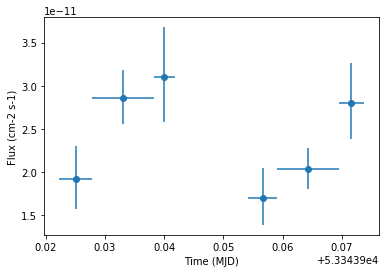

In [15]:
lc_1d.plot(marker="o")